# Reinforcement Learning for Bipedal Walker game

Import libraries:

In [1]:
import numpy as np
import tensorflow as tf
import gym
import matplotlib.pyplot as plt
% matplotlib notebook

c:\python36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### Defining hyperparameters:

Here we define all the hyperparameters for the model, this will allow as to easily iterate and find the values that give best results.

In [2]:
num_episodes = 10      # Number of episodes for training
learning_rate = 0.001
gamma = 0.99           # Discount factor for reward
num_Hidden = 200       # number of nodes in the hidden layer

env = gym.make('BipedalWalker-v2')    # Choose a game and create an environment
env._max_episode_steps = 50000
# env = env.unwrapped              # The wrapper limits the number of steps in an episode, let's get rid of it
obs_dim = env.reset().shape      # obervation dimension
num_actions = len(env.action_space.high) # number of actions (this works only for continuous action space, which is the case here)

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


### Define functions

**Discount reward function**: We we'll train our agent based on the reward gained for his actions. For each action we'll define the episode reward as the total reward gained in all the next steps of the current episode. Since a reward gained further away in the future has less correlation to the present action, we will give it less weight by discounting future rewards.

The formula for the discounted rewards is given by:

$$ R_t = \sum_k \gamma^k r_{t+k} $$

Where $r_t$ is the reward gained in the step $t$ and $\gamma \in [0,1]$ is a hyperparameter called the discount factor.
Here we define a function that takes a vector of rewards in consequent steps and returns the discounted reward vector:

In [3]:
def discount_rewards(r):
    '''Takes a 1D rewards (one episode) and discounts it and also standardize
    the rewards to be unit normal (helps control the gradient estimator variance)'''
    
    # Discounting
    dis_r = np.zeros_like(r)
    running_sum = 0
    for t in reversed(range(len(r))):
        running_sum = gamma*running_sum + r[t]
        dis_r[t] = running_sum
    
    # Normailzing
    dis_r = (dis_r - np.mean(dis_r))/np.std(dis_r)
        
    return dis_r

### Build model

This game takes a continuous range of values for each action. In the Gym library language, the action space is a Box instead of Discrete

In [4]:
print(env.action_space)
print(env.action_space.high)
print(env.action_space.low)

Box(4,)
[1. 1. 1. 1.]
[-1. -1. -1. -1.]


In this case, each action is a vector of length 4 where every element value is in the [-1,1] domain. We will use Gaussian policy to train this model. Our NN would output the 4 mean values and 4 std values for each element of the action vector, and then use them to generate actions in each step.

To keep order in our model, we use name scopes which basically group the layers of our model in a simple to follow way. Eventually, when using [TensorBoard](https://www.tensorflow.org/guide/summaries_and_tensorboard) for visualizing the model, the graph is more readable and makes it easy to understand the model and find errors.

In [5]:
'''Create placeholders for inputs'''
# A place holder for input observations
input_ = tf.placeholder(tf.float32, shape = (None, obs_dim[0]), name = "input")
# A place holder for actions in a full episode
actions = tf.placeholder(tf.float32, shape = (None, num_actions), name = "actions")
# A place holder for discounted rewards in a full episode
dis_rewards = tf.placeholder(tf.float32, shape = (None, ), name = "dis_rewards")

'''Fully connected layers'''
# A network channel for predicting the mean values of the action PDF
with tf.name_scope("Mean_channel"):
    Mfc1 = tf.layers.dense(inputs = input_, units = num_Hidden ,activation = tf.nn.relu, name = "Mfc1" )
    Mfc2 = tf.layers.dense(inputs = Mfc1, units = num_actions ,activation = None, name = "Mfc2")

    # A network channel for predicting the std values of the action PDF
with tf.name_scope("Std_channel"):
    Sfc1 = tf.layers.dense(inputs = input_, units = num_Hidden ,activation = tf.nn.relu, name = "Sfc1" )
    # We use a softplus activation for the last layer to ensure positive std value
    Sfc2 = tf.layers.dense(inputs = input_, units = num_actions ,activation = tf.nn.softplus, name = "Sfc2" )
    
    
with tf.name_scope("Action_PDF"):
    # Use the predicted mean and std for creating a probabilty distribution for actions
    action_prob_dist = tf.contrib.distributions.Normal(loc = Mfc2, scale = Sfc2 + 1e-6, name = "Normal_PDF")
    sample_action = action_prob_dist.sample([1], name = "sample_action")

with tf.name_scope("Loss"):
    '''Define loss'''
    # compute negative log probability using our PDF and sum over the actions in every time step
    negative_logprob = - tf.reduce_sum(action_prob_dist.log_prob(actions), axis = 1)
    # Modulate the loss based on our discounted reward - this is where reinforcment learning happens,
    # we favor actions that produced high reward
    loss = tf.reduce_mean(negative_logprob * dis_rewards, name = "loss")

with tf.name_scope("Training"):
    '''Define optimizer'''
    training_opt = tf.train.AdamOptimizer(learning_rate).minimize(loss)

'''Define saver for saving and restoring model'''
saver = tf.train.Saver()

Define a writer for saving summaries to TensorBoard:

In [6]:
# writer = tf.summary.FileWriter("./tensorboard/1/")

### Train model

Now that we have a model ready, we can start training it.

Our goal is to achieve a model that uses the current observation to create the best probability distribution function (PDF) for the next action to be taken. This is **not a deterministic model** - the agent has a fine probability to take any action after receiving an observation, with larger probability to take favorable actions.

To achieve that, in each step, we use our model to generate a PDF of actions, draw an action out of it and take the next step.
When we reach the end of the episode, we compute the episode loss by feeding the observation, action and discounted rewards vectors (which we kept track of). Our optimizer minimizes the loss which makes favorable (unfavorable) actions more probable (less probable) due to the multiplicative factor of the discounted reward. By repeating these steps to each episode, our agent gradually improves its PDF and becomes a better player!

In [7]:
ep_action, ep_obs, ep_reward = [], [], []  # Allocate space for episode actions, observations and rewards
tot_ep_reward = [] # Total episode reward
mean_reward = []

''' Run TF session '''
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    ''' Run episodes '''
    for ep in range(num_episodes): 
        obs = env.reset()  # Reset and save first observation
        ep_obs.append(obs) # append observation

        ''' Run steps '''
        while True:
            # Propagate forward to compute action probability distribution and sample an action out of it
            action = np.squeeze(sess.run(sample_action, feed_dict = {input_ : obs.reshape((1,obs_dim[0]))}))
            # clip action values to fit into the allowed box
            action = np.clip(action, env.action_space.low[0], env.action_space.high[0])
            
            obs, reward, done, info = env.step(action)  # Take action and save observation, reward and done boolean
            
            ep_action.append(action)     # append action
            ep_obs.append(obs)           # append observation
            ep_reward.append(reward)     # append reward

            if done: 
                # Stack vertically episode parameters to one np.array
                ep_action = np.vstack(ep_action)
                ep_obs = np.vstack(ep_obs)
                ep_reward = np.hstack(ep_reward)

                # Discount rewards
                dis_rewards_arr = discount_rewards(ep_reward)
                # Compute loss and optimize
                sess.run([loss, training_opt],
                         feed_dict = {input_ : ep_obs[:-1], actions : ep_action, dis_rewards : dis_rewards_arr})
                
                tot_ep_reward.append(np.sum(ep_reward))  # Compute total reward for episode
                mean_reward.append(np.mean(tot_ep_reward))
                
                 # print info
                print("-------------------------------------------------")
                print("Episode {}".format(ep))
                print("Episode ended after {} steps".format(ep_action.shape[0]))
                print("Accumulated reward in this episode {}".format(tot_ep_reward[ep]))
                print("Mean reward so far {:0.2f}".format(np.mean(tot_ep_reward)))
                print("Maximal reward so far {}".format(np.max(tot_ep_reward)))
                
                ep_action, ep_obs, ep_reward = [], [], []  # Clear episode values for next episode
                      
                break
                
    saver.save(sess, "models/BipedalWalker/model.ckpt") # save model for later
#     writer.add_graph(sess.graph) # Save graph for displaying with TensorBoard
env.close()

-------------------------------------------------
Episode 0
Episode ended after 50000 steps
Accumulated reward in this episode -2778.275897232385
Mean reward so far -2778.28
Maximal reward so far -2778.275897232385
-------------------------------------------------
Episode 1
Episode ended after 50000 steps
Accumulated reward in this episode -2775.6191735740645
Mean reward so far -2776.95
Maximal reward so far -2775.6191735740645
-------------------------------------------------
Episode 2
Episode ended after 61 steps
Accumulated reward in this episode -111.66839358102467
Mean reward so far -1888.52
Maximal reward so far -111.66839358102467
-------------------------------------------------
Episode 3
Episode ended after 50000 steps
Accumulated reward in this episode -2842.2863709220237
Mean reward so far -2126.96
Maximal reward so far -111.66839358102467
-------------------------------------------------
Episode 4
Episode ended after 50000 steps
Accumulated reward in this episode -2809.0402

### Assess model performance

In order to get a sense of how good our model is, and to see if our agent improves in the training process, we can plot the mean rewards gained in one episode over the episode number. This value would grow as our agent becomes more skilled and gains more rewards in each episode.

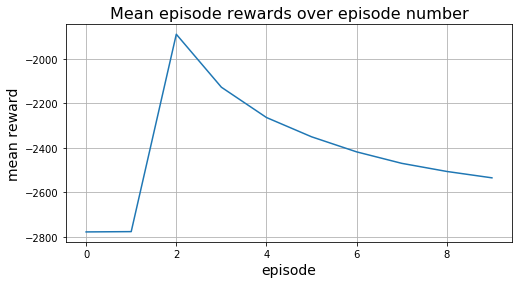

In [8]:
plt.figure(figsize=(8,4))
plt.plot(mean_reward)
plt.xlabel("episode", fontsize=14)
plt.ylabel("mean reward", fontsize = 14)
plt.title("Mean episode rewards over episode number", fontsize = 16)
plt.grid()

### Watch the agent play an episode

This is the fun part!
Now we get to see how good our agent really is by watching it play an episode.

In [9]:
ep_reward = []
env = gym.make('BipedalWalker-v2')
# env._max_episode_steps = 1000
# env = gym.wrappers.Monitor(env, "recording/LunarLander")
with tf.Session() as sess:
    saver.restore(sess, "models/BipedalWalker/model.ckpt") # load model
    obs = env.reset() # Reset env and save observation
    t = 0
    while True:
        env.render() # Render game
        # Use our model to create a probability distribution of actions based on observation
        action = np.squeeze(sess.run(sample_action, feed_dict = {input_ : obs.reshape((1,obs_dim[0]))}))
        action = np.clip(action,-1, 1) # clip action values to fit into the allowed box
        obs, reward, done, info = env.step(action)
        ep_reward.append(reward)
        t = t+1
        if done:
            print("Game ended after {} steps".format(t+1))
            print("Total reward earned in this episode: {:0.2f}".format(sum(ep_reward)))
            break
env.close()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
INFO:tensorflow:Restoring parameters from models/BipedalWalker/model.ckpt
Game ended after 1601 steps
Total reward earned in this episode: -84.01
